==== Optimal Parameters (gm and CL fixed) ====
gm   = 1.000 mS   (fixed)
CL   = 0.100 pF  (fixed)
RS   = 1,049.8 Ω
RD   = 1,590.6 Ω
CS   = 0.332 pF

==== Corner Frequencies ====
fz   = 456.44  MHz
fp1  = 696.03  MHz
fp2  = 1000.60  MHz

==== Gains ====
boost     = 1.525  (3.66 dB)  [<= 10 dB enforced]
Kdc |K|   = 1.043  (0.37 dB)
A_peak    = gm*RD = 1.591


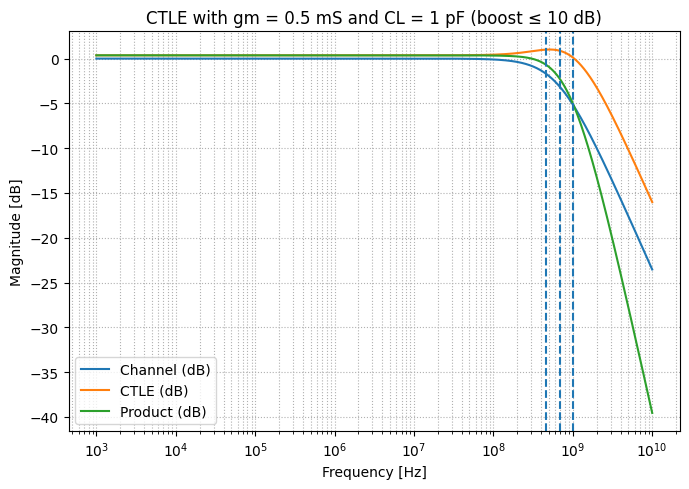

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ====== Specs ======
f_nyq = 2e9
fmin, fmax = 1e3, 10e9
F = np.logspace(np.log10(fmin), np.log10(fmax), 800)

# Channel: 1st-order with |H(f_nyq)| = -40 dB
# |H| = 1 / sqrt(1 + (f/fc)^2)  =>  fc = f_nyq / sqrt(10^(40/10)-1)
ATTEN_DB = 10.0
fc = f_nyq / np.sqrt(10**(ATTEN_DB/10) - 1)
wc = 2*np.pi*fc

def H_ch_mag(f):
    w = 2*np.pi*f
    return 1.0 / np.sqrt(1.0 + (w/wc)**2)

# ====== CTLE with fixed CL and gm ======
CL_FIXED = 100e-15     # 100 fF (fixed)
GM_FIXED = 1e-3    # 0.5 mS (fixed)


def ctle_params_to_freqs(RS, RD, CS, gm=GM_FIXED, CL=CL_FIXED):
    boost = 1.0 + gm*RS/2.0                         # linear
    fz  = 1.0/(2*np.pi*RS*CS)
    fp1 = boost/(2*np.pi*RS*CS)
    fp2 = 1.0/(2*np.pi*RD*CL)
    Kdc = (gm*RD)/boost
    Apeak = gm*RD
    return fz, fp1, fp2, boost, Kdc, Apeak

def H_ctle_mag(f, RS, RD, CS, gm=GM_FIXED, CL=CL_FIXED):
    fz, fp1, fp2, boost, Kdc, _ = ctle_params_to_freqs(RS, RD, CS, gm, CL)
    w = 2*np.pi*f
    wz, wp1, wp2 = 2*np.pi*np.array([fz, fp1, fp2])
    num  = np.sqrt(1.0 + (w/wz)**2)
    den  = np.sqrt(1.0 + (w/wp1)**2) * np.sqrt(1.0 + (w/wp2)**2)
    return abs(Kdc) * (num/den)

# ====== Objective ======
def objective(x, want_midband_boost_db=8.0, lambda_boost=0.15):
    RS, RD, CS = x

    # Physical limits (wider RS range because gm is modest)
    if not (100 <= RS <= 200e3 and 100 <= RD <= 20e3 and 1e-14 <= CS <= 1e-11):
        return 1e12

    fz, fp1, fp2, boost_lin, Kdc, _ = ctle_params_to_freqs(RS, RD, CS)

    # Hard constraints / penalties
    pen = 0.0
    if not (fz < fp1 < fp2):           # proper ordering
        pen += 5.0

    # fp2 should not roll off before Nyquist too much
    if fp2 < 0.5*f_nyq:
        pen += (0.5*f_nyq/fp2 - 1.0)

    # DC gain sanity window (±10 dB)
    Kdc_db = 20*np.log10(max(Kdc, 1e-12))
    if Kdc_db < -10: pen += (-10 - Kdc_db)/10
    if Kdc_db >  10: pen += ( Kdc_db - 10)/10

    # Enforce boost <= 10 dB
    boost_db = 20*np.log10(max(boost_lin, 1e-12))
    if boost_db > 10.0:
        pen += 10.0 * (boost_db - 10.0)  # strong penalty

    # Gentle target for midband boost (optional)
    f1 = max(fp1*1.2, fmin)
    f2 = min(fp2/1.2, f_nyq)
    if f2 > f1:
        ff = np.logspace(np.log10(f1), np.log10(f2), 40)
        mid = np.mean(H_ctle_mag(ff, RS, RD, CS))
        mid_db = 20*np.log10(mid + 1e-18)
        pen += lambda_boost * (mid_db - want_midband_boost_db)**2

    # Equalization error (product ≈ 1 over band)
    Htot = H_ctle_mag(F, RS, RD, CS) * H_ch_mag(F)
    err = np.mean((np.log10(np.maximum(Htot, 1e-18)))**2)  # ~ dB^2
    return err + pen

# ====== Random search + local refinement ======
rng = np.random.default_rng(0)

def random_sample():
    RS = 10**rng.uniform(np.log10(1e2),  np.log10(2e5))
    RD = 10**rng.uniform(np.log10(1e2),  np.log10(2e4))
    CS = 10**rng.uniform(np.log10(1e-14), np.log10(1e-11))
    return np.array([RS, RD, CS])

best, best_cost = None, 1e99
for _ in range(6000):
    x = random_sample()
    c = objective(x)
    if c < best_cost:
        best, best_cost = x, c

scales = np.array([1.5, 1.3, 1.3])
for _ in range(2000):
    trial = best * (scales**rng.normal(0, 0.25, size=3))
    c = objective(trial)
    if c < best_cost:
        best, best_cost = trial, c

RS, RD, CS = best
fz, fp1, fp2, boost_lin, Kdc, Apeak = ctle_params_to_freqs(RS, RD, CS)

print("==== Optimal Parameters (gm and CL fixed) ====")
print(f"gm   = {GM_FIXED*1e3:.3f} mS   (fixed)")
print(f"CL   = {CL_FIXED*1e12:.3f} pF  (fixed)")
print(f"RS   = {RS:,.1f} Ω")
print(f"RD   = {RD:,.1f} Ω")
print(f"CS   = {CS*1e12:.3f} pF")
print("\n==== Corner Frequencies ====")
print(f"fz   = {fz/1e6:.2f}  MHz")
print(f"fp1  = {fp1/1e6:.2f}  MHz")
print(f"fp2  = {fp2/1e6:.2f}  MHz")
print("\n==== Gains ====")
print(f"boost     = {boost_lin:.3f}  ({20*np.log10(boost_lin):.2f} dB)  [<= 10 dB enforced]")
print(f"Kdc |K|   = {Kdc:.3f}  ({20*np.log10(max(Kdc,1e-12)):.2f} dB)")
print(f"A_peak    = gm*RD = {Apeak:.3f}")

# ====== Plots ======
Hctle = H_ctle_mag(F, RS, RD, CS)
Htot  = Hctle * H_ch_mag(F)

plt.figure(figsize=(7,5))
plt.semilogx(F, 20*np.log10(H_ch_mag(F)), label="Channel (dB)")
plt.semilogx(F, 20*np.log10(Hctle),       label="CTLE (dB)")
plt.semilogx(F, 20*np.log10(Htot),        label="Product (dB)")
plt.axvline(fz,  linestyle="--")
plt.axvline(fp1, linestyle="--")
plt.axvline(fp2, linestyle="--")
plt.title("CTLE with gm = 0.5 mS and CL = 1 pF (boost ≤ 10 dB)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.show()


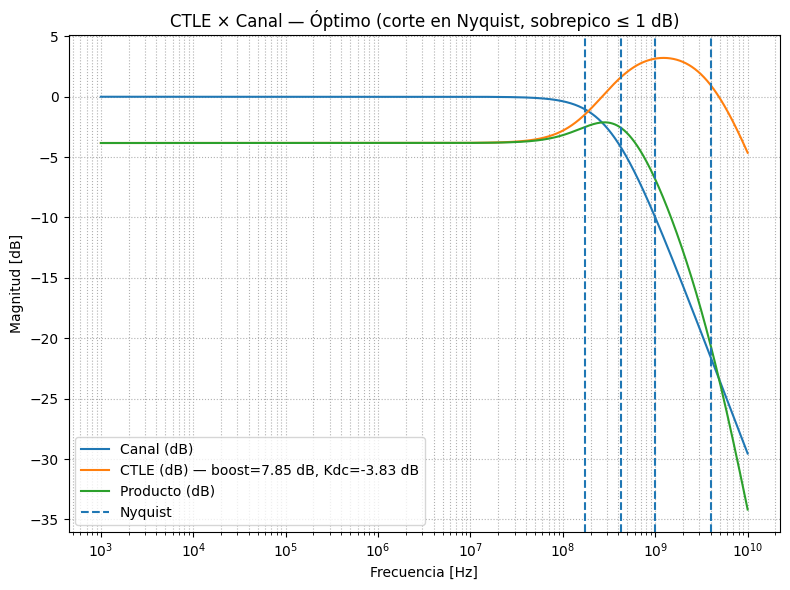


Guardados: c:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\ctle_sweep_all.csv, c:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\ctle_sweep_feasible.csv, c:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\ctle_stats.json
Óptimo guardado en: c:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\ctle_optimo.json
Resumen óptimo: {'fz': np.float64(172137911.88348743), 'fp1': np.float64(424953184.51535404), 'fp2': np.float64(3975235516.612191), 'boost_db': np.float64(7.849291152940014), 'Kdc_db': np.float64(-3.831055045654055), 'Htot_low_db': np.float64(-3.8310550455708983), 'Htot_nyq_db': np.float64(-6.842400323330486), 'Htot_peak_db': -2.120015263176564, 'peak_over_nyq_db': 4.722385060153922, 'cut_err_db': np.float64(0.011345277759588157)}


In [2]:
# ctle_montecarlo_optimo_en_nyquist.py
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# (Opcional) Pandas
try:
    import pandas as pd
    HAVE_PANDAS = True
except Exception:
    HAVE_PANDAS = False

# ===================== Especificaciones globales =====================
f_nyq = 1e9                 # Nyquist = 1 GHz
fmin, fmax = 1e3, 10e9
N_F = 2**16
F = np.logspace(np.log10(fmin), np.log10(fmax), N_F)  # malla log-f

ATTEN_DB = 10.0  # Atenuación del canal en Nyquist (modelo 1 polo)
fc = f_nyq / np.sqrt(10**(ATTEN_DB/10) - 1.0)  # OJO: /10 correcto

# ===================== Canal (1 polo) =====================
def H_ch_mag(f):
    w = 2*np.pi*f
    wc = 2*np.pi*fc
    return 1.0 / np.sqrt(1.0 + (w/wc)**2)

H_CH = H_ch_mag(F)

# ===================== CTLE (cero + 2 polos) =====================
def ctle_params_to_freqs(RS, RD, CS, gm, CL):
    boost = 1.0 + gm*RS/2.0
    fz  = 1.0/(2*np.pi*RS*CS)
    fp1 = boost/(2*np.pi*RS*CS)
    fp2 = 1.0/(2*np.pi*RD*CL)
    Kdc = (gm*RD)/max(boost, 1e-18)
    Apeak = gm*RD
    return fz, fp1, fp2, boost, Kdc, Apeak

def H_ctle_mag_vec(f, RS, RD, CS, gm, CL):
    fz, fp1, fp2, boost, Kdc, _ = ctle_params_to_freqs(RS, RD, CS, gm, CL)
    w = 2*np.pi*f
    wz, wp1, wp2 = 2*np.pi*np.array([fz, fp1, fp2])
    num  = np.sqrt(1.0 + (w/wz)**2)
    den  = np.sqrt(1.0 + (w/wp1)**2) * np.sqrt(1.0 + (w/wp2)**2)
    return abs(Kdc) * (num/den)

def maxval(x):
    x = np.asarray(x)
    return np.maximum(x, 1e-18)

# ===================== Guardrails mínimos (sin "score") =====================
Z_MAX_FRAC_NYQ = 1
P1_MIN_FRAC    = 0.0001
P1_MAX_FRAC    = 1
MIN_SEP_Z_P1   = 0.0001     # fp1 >= 0.5 * fz
MIN_SEP_P1_P2  = 0.0001     # fp2 >= 0.3 * fp1

# ===================== Especificación de óptimo en el PRODUCTO =====================
CUT_TOL_DB   = 10   # tolerancia para -3 dB en Nyquist
PEAK_MAX_DB  = 5   # sobrepico máximo permitido
PK_ALPHA     = 1.2   # barrido de pico hasta 1.2*Nyquist
F_LOW_EVAL   = max(fmin, 1e3)  # "casi DC" para referencia de corte

def evaluate_set(RS, RD, CS, gm, CL):
    # Frecs/ganancias del CTLE
    fz, fp1, fp2, boost_lin, Kdc, _ = ctle_params_to_freqs(RS, RD, CS, gm, CL)
    boost_db = 20*np.log10(max(boost_lin, 1e-18))
    Kdc_db   = 20*np.log10(max(Kdc, 1e-18))

    # Guardrails básicos (orden/rangos)
    ok_order_basic = (fz < fp1) and (fp1 < fp2)
    ok_fp2_bw      = (0.0001 * f_nyq <= fp2 <= 4 * f_nyq)
    ok_fz_band     = (fz <= Z_MAX_FRAC_NYQ * f_nyq)
    ok_fp1_band    = (P1_MIN_FRAC * f_nyq <= fp1 <= P1_MAX_FRAC * f_nyq)
    ok_seps        = (fp1 >= MIN_SEP_Z_P1 * fz) and (fp2 >= MIN_SEP_P1_P2 * fp1)
    ok_boost       = (boost_db <= 10.0)
    ok_kdc         = (-10.0 <= Kdc_db <= 10.0)

    # Producto en puntos clave
    def Htot_mag(f):
        return H_ctle_mag_vec(np.atleast_1d(f), RS, RD, CS, gm, CL)[0] * H_ch_mag(np.atleast_1d(f))[0]
    def db(x): return 20*np.log10(max(x, 1e-18))

    Hctle_low_db = db(H_ctle_mag_vec(np.atleast_1d(F_LOW_EVAL), RS, RD, CS, gm, CL)[0])
    Hctle_nyq_db = db(H_ctle_mag_vec(np.atleast_1d(f_nyq), RS, RD, CS, gm, CL)[0])
    Htot_low_db  = db(Htot_mag(F_LOW_EVAL))
    Htot_nyq_db  = db(Htot_mag(f_nyq))

    # Peaking en banda (hasta PK_ALPHA * Nyquist)
    Fpk    = np.logspace(np.log10(F_LOW_EVAL), np.log10(min(PK_ALPHA*f_nyq, fmax)), 256)
    Hpk_db = 20*np.log10(maxval(H_ctle_mag_vec(Fpk, RS, RD, CS, gm, CL) * H_ch_mag(Fpk)))
    Htot_peak_db = float(np.max(Hpk_db))
    peak_over_nyq_db = float(Htot_peak_db - Htot_nyq_db)

    # ---- Restricciones duras de "óptimo" ----
    # Corte en Nyquist: |Htot(f_nyq)| ≈ |Htot(f_low)| - 3 dB
    cut_err_db = abs((Htot_low_db - 3.0) - Htot_nyq_db)
    ok_cut_at_nyq = (cut_err_db <= CUT_TOL_DB)

    # Sobrepico limitado
    ok_peak = (peak_over_nyq_db <= PEAK_MAX_DB)

    hard_ok = (
        ok_order_basic and ok_fp2_bw and ok_fz_band and ok_fp1_band and ok_seps and ok_boost and ok_kdc
        and ok_cut_at_nyq and ok_peak
    )

    return {
        "RS": RS, "RD": RD, "CS": CS, "gm": gm, "CL": CL,
        "fz": fz, "fp1": fp1, "fp2": fp2,
        "boost_db": boost_db, "Kdc_db": Kdc_db,
        "Hctle_low_db": Hctle_low_db, "Hctle_nyq_db": Hctle_nyq_db,
        "Htot_low_db": Htot_low_db, "Htot_nyq_db": Htot_nyq_db,
        "Htot_peak_db": Htot_peak_db, "peak_over_nyq_db": peak_over_nyq_db,
        "cut_err_db": cut_err_db,
        "hard_ok": hard_ok
    }

# ===================== Rangos de muestreo =====================
RANGES = {
    "RS": (1e2,   50e3),
    "RD": (1e2,   50e3),
    "CS": (1e-15, 1e-12),
    "gm": (0.1e-3, 1e-3),
    "CL": (10e-15, 100e-15),
}

def sample_log_uniform(low, high, size):
    return 10**np.random.uniform(np.log10(low), np.log10(high), size=size)

def draw_population(N):
    RS = sample_log_uniform(*RANGES["RS"], N)
    RD = sample_log_uniform(*RANGES["RD"], N)
    CS = sample_log_uniform(*RANGES["CS"], N)
    gm = sample_log_uniform(*RANGES["gm"], N)
    CL = sample_log_uniform(*RANGES["CL"], N)
    return RS, RD, CS, gm, CL

# ===================== Monte Carlo =====================
np.random.seed(42)
N = 50000
RS, RD, CS, gm, CL = draw_population(N)

records = []
for i in range(N):
    records.append(evaluate_set(RS[i], RD[i], CS[i], gm[i], CL[i]))

# ===================== Filtrado & “óptimo” =====================
feasible = [r for r in records if r["hard_ok"]]
pass_rate = len(feasible) / len(records) if records else 0.0

# Definición de “óptimo”: minimizar error de corte, desempatar por menor sobrepico
def opt_key(r):
    return (r["cut_err_db"], r["peak_over_nyq_db"])

opt = min(feasible, key=opt_key) if feasible else None

# ===================== Guardado / tablas =====================
out_all = "ctle_sweep_all.csv"
out_fe  = "ctle_sweep_feasible.csv"
out_opt = "ctle_optimo.json"
out_js  = "ctle_stats.json"

def to_csv(path, rows):
    if not rows:
        open(path, "w").close(); return
    keys = list(rows[0].keys())
    with open(path, "w") as f:
        f.write(",".join(keys) + "\n")
        for r in rows:
            f.write(",".join(str(r.get(k, "")) for k in keys) + "\n")

if HAVE_PANDAS:
    pd.DataFrame.from_records(records).to_csv(out_all, index=False)
    pd.DataFrame.from_records(feasible).to_csv(out_fe, index=False)
else:
    to_csv(out_all, records)
    to_csv(out_fe, feasible)

if opt is not None:
    with open(out_opt, "w") as f:
        json.dump(opt, f, indent=2)

# Estadísticas básicas (solo de los factibles)
def summarize(vals):
    v = np.asarray(vals)
    return {
        "min": float(np.min(v)),
        "p25": float(np.quantile(v, 0.25)),
        "median": float(np.quantile(v, 0.50)),
        "p75": float(np.quantile(v, 0.75)),
        "max": float(np.max(v)),
        "mean": float(np.mean(v)),
    }

def s(key):
    return summarize([r[key] for r in feasible]) if feasible else None

stats = {
    "N_total": len(records),
    "N_feasible": len(feasible),
    "pass_rate": pass_rate,
    "fz": s("fz"), "fp1": s("fp1"), "fp2": s("fp2"),
    "boost_db": s("boost_db"), "Kdc_db": s("Kdc_db"),
    "Htot_low_db": s("Htot_low_db"), "Htot_nyq_db": s("Htot_nyq_db"),
    "Htot_peak_db": s("Htot_peak_db"), "peak_over_nyq_db": s("peak_over_nyq_db"),
}
with open(out_js, "w") as f:
    json.dump(stats, f, indent=2)

# ===================== Plot del óptimo =====================
if opt is not None:
    Hctle_opt = H_ctle_mag_vec(F, opt["RS"], opt["RD"], opt["CS"], opt["gm"], opt["CL"])
    Htot_opt  = Hctle_opt * H_CH

    plt.figure(figsize=(8,6))
    plt.semilogx(F, 20*np.log10(H_CH), label="Canal (dB)")
    plt.semilogx(F, 20*np.log10(maxval(Hctle_opt)), label=f"CTLE (dB) — boost={opt['boost_db']:.2f} dB, Kdc={opt['Kdc_db']:.2f} dB")
    plt.semilogx(F, 20*np.log10(maxval(Htot_opt)), label="Producto (dB)")
    plt.axvline(opt["fz"],  linestyle="--")
    plt.axvline(opt["fp1"], linestyle="--")
    plt.axvline(opt["fp2"], linestyle="--")
    plt.axvline(f_nyq, linestyle="--", label="Nyquist")
    plt.title("CTLE × Canal — Óptimo (corte en Nyquist, sobrepico ≤ 1 dB)")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Magnitud [dB]")
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===================== Info final =====================
print(f"\nGuardados: {os.path.abspath(out_all)}, {os.path.abspath(out_fe)}, {os.path.abspath(out_js)}")
if opt is not None:
    print(f"Óptimo guardado en: {os.path.abspath(out_opt)}")
    print("Resumen óptimo:", {k: opt[k] for k in ["fz","fp1","fp2","boost_db","Kdc_db","Htot_low_db","Htot_nyq_db","Htot_peak_db","peak_over_nyq_db","cut_err_db"]})
else:
    print("No se encontró solución que cumpla corte≈Nyquist y sobrepico ≤ 1 dB. Amplía N o relaja CUT_TOL_DB ligeramente.")


In [3]:
# Cargar las soluciones factibles y calcular estadísticas (min, media, max) de cada variable
import pandas as pd
import numpy as np

# Intentar leer el archivo generado previamente
fe_path = "ctle_sweep_feasible.csv"
df = pd.read_csv(fe_path)

# Seleccionar columnas de interés
cols = ["RS","RD","CS","gm","CL","boost_db","Kdc_db","fz","fp1","fp2","score"]
available = [c for c in cols if c in df.columns]
df_sel = df[available].copy()

# Crear estadísticas básicas
summary = pd.DataFrame({
    "min": df_sel.min(),
    "mean": df_sel.mean(),
    "max": df_sel.max()
})

# Añadir versiones en unidades más legibles para algunas variables
unit_view = pd.DataFrame(index=["RS[kΩ]","RD[kΩ]","CS[pF]","gm[mS]","CL[fF]","fz[MHz]","fp1[MHz]","fp2[MHz]"])
def add_scaled_row(name, series, scale, label):
    if name in df_sel.columns:
        unit_view.loc[label, "min"]  = series.min()*scale
        unit_view.loc[label, "mean"] = series.mean()*scale
        unit_view.loc[label, "max"]  = series.max()*scale

add_scaled_row("RS",   df_sel.get("RS"),   1e-3, "RS[kΩ]")
add_scaled_row("RD",   df_sel.get("RD"),   1e-3, "RD[kΩ]")
add_scaled_row("CS",   df_sel.get("CS"),   1e12, "CS[pF]")
add_scaled_row("gm",   df_sel.get("gm"),   1e3,  "gm[mS]")
add_scaled_row("CL",   df_sel.get("CL"),   1e15, "CL[fF]")
add_scaled_row("fz",   df_sel.get("fz"),   1e-6, "fz[MHz]")
add_scaled_row("fp1",  df_sel.get("fp1"),  1e-6, "fp1[MHz]")
add_scaled_row("fp2",  df_sel.get("fp2"),  1e-6, "fp2[MHz]")

# Guardar tablas
summary_path = "ctle_feasible_stats_min_mean_max.csv"
units_path   = "ctle_feasible_stats_units.csv"
summary.to_csv(summary_path)
unit_view.to_csv(units_path)

summary, unit_view, (summary_path, units_path)


(                   min          mean           max
 RS        3.167208e+03  8.134503e+03  2.528902e+04
 RD        1.026323e+03  4.092443e+03  9.772098e+03
 CS        2.336418e-14  1.248067e-13  3.067218e-13
 gm        1.325622e-04  5.833883e-04  9.564116e-04
 CL        1.011958e-14  2.156091e-14  6.329278e-14
 boost_db  7.095052e+00  8.807703e+00  9.928980e+00
 Kdc_db   -9.674653e+00 -3.558223e+00  8.397420e+00
 fz        1.259783e+08  2.325830e+08  3.694308e+08
 fp1       3.690042e+08  6.410092e+08  9.391317e+08
 fp2       1.413470e+09  2.498356e+09  3.975236e+09,
                   min         mean          max
 RS[kΩ]       3.167208     8.134503    25.289021
 RD[kΩ]       1.026323     4.092443     9.772098
 CS[pF]       0.023364     0.124807     0.306722
 gm[mS]       0.132562     0.583388     0.956412
 CL[fF]      10.119580    21.560906    63.292776
 fz[MHz]    125.978332   232.583046   369.430778
 fp1[MHz]   369.004243   641.009232   939.131679
 fp2[MHz]  1413.469627  2498.356141

In [4]:
# === Stats + parámetros del PRODUCTO (CTLE × Canal) ===
import pandas as pd
import numpy as np

# ----------------- Config de evaluación -----------------
f_nyq = 1e9
fmin, fmax = 1e3, 10e9
N_F = 1024
F = np.logspace(np.log10(fmin), np.log10(fmax), N_F)
F_LOW_EVAL = max(fmin, 1e3)     # “casi DC” para referencia
PK_ALPHA   = 1.2                # para barrer el pico hasta 1.2*Nyquist

ATTEN_DB = 10.0                 # atenuación del canal en Nyquist (modelo 1 polo)
# ¡Correcto: /10!
fc = f_nyq / np.sqrt(10**(ATTEN_DB/10) - 1.0)

def H_ch_mag(f):
    w = 2*np.pi*f
    wc = 2*np.pi*fc
    return 1.0 / np.sqrt(1.0 + (w/wc)**2)

def ctle_params_to_freqs(RS, RD, CS, gm, CL):
    boost = 1.0 + gm*RS/2.0
    fz  = 1.0/(2*np.pi*RS*CS)
    fp1 = boost/(2*np.pi*RS*CS)
    fp2 = 1.0/(2*np.pi*RD*CL)
    Kdc = (gm*RD)/max(boost, 1e-18)
    return fz, fp1, fp2, boost, Kdc

def H_ctle_mag_vec(f, RS, RD, CS, gm, CL):
    fz, fp1, fp2, boost, Kdc = ctle_params_to_freqs(RS, RD, CS, gm, CL)
    w = 2*np.pi*f
    wz, wp1, wp2 = 2*np.pi*np.array([fz, fp1, fp2])
    num  = np.sqrt(1.0 + (w/wz)**2)
    den  = np.sqrt(1.0 + (w/wp1)**2) * np.sqrt(1.0 + (w/wp2)**2)
    return abs(Kdc) * (num/den)

def db(x): 
    return 20*np.log10(np.maximum(x, 1e-18))

# ----------------- Cargar CSV -----------------
fe_path = "ctle_sweep_feasible.csv"
df = pd.read_csv(fe_path)

# ----------------- Calcular/Completar métricas del PRODUCTO -----------------
need_cols = ["Htot_low_db","Htot_nyq_db","Htot_peak_db","peak_over_nyq_db","cut_err_db"]
have_cols = [c for c in need_cols if c in df.columns]

if len(have_cols) < len(need_cols):
    # calcular faltantes fila a fila
    def compute_product_metrics(row):
        RS, RD, CS, gm, CL = row["RS"], row["RD"], row["CS"], row["gm"], row["CL"]

        # CTLE y canal en puntos clave
        Hctle_low = H_ctle_mag_vec(np.atleast_1d(F_LOW_EVAL), RS, RD, CS, gm, CL)[0]
        Hctle_nyq = H_ctle_mag_vec(np.atleast_1d(f_nyq),    RS, RD, CS, gm, CL)[0]
        Htot_low  = Hctle_low * H_ch_mag(np.atleast_1d(F_LOW_EVAL))[0]
        Htot_nyq  = Hctle_nyq * H_ch_mag(np.atleast_1d(f_nyq))[0]

        # Pico en banda
        Fpk = np.logspace(np.log10(F_LOW_EVAL), np.log10(min(PK_ALPHA*f_nyq, fmax)), 256)
        Htot_pk = H_ctle_mag_vec(Fpk, RS, RD, CS, gm, CL) * H_ch_mag(Fpk)
        Htot_peak_db = float(np.max(db(Htot_pk)))
        Htot_nyq_db  = float(db(Htot_nyq))
        peak_over_nyq_db = Htot_peak_db - Htot_nyq_db

        # Error de corte en Nyquist (target ~ -3 dB desde baja frecuencia)
        cut_err_db = abs((float(db(Htot_low)) - 3.0) - Htot_nyq_db)

        return pd.Series({
            "Htot_low_db": float(db(Htot_low)),
            "Htot_nyq_db": Htot_nyq_db,
            "Htot_peak_db": Htot_peak_db,
            "peak_over_nyq_db": float(peak_over_nyq_db),
            "cut_err_db": float(cut_err_db),
            # también útil dejar CTLE en puntos clave si no están
            "Hctle_low_db": float(db(Hctle_low)),
            "Hctle_nyq_db": float(db(Hctle_nyq)),
        })

    prod_df = df.apply(compute_product_metrics, axis=1)
    for c in prod_df.columns:
        if c not in df.columns:
            df[c] = prod_df[c]

# ----------------- Stats de DISEÑO (RS, RD, CS, gm, CL, fz, fp1, fp2, boost, Kdc) -----------------
cols_design = ["RS","RD","CS","gm","CL","boost_db","Kdc_db","fz","fp1","fp2"]
cols_design = [c for c in cols_design if c in df.columns]
df_design = df[cols_design].copy()

summary = pd.DataFrame({
    "min":  df_design.min(),
    "mean": df_design.mean(),
    "max":  df_design.max()
})

unit_view = pd.DataFrame(index=["RS[kΩ]","RD[kΩ]","CS[pF]","gm[mS]","CL[fF]","fz[MHz]","fp1[MHz]","fp2[MHz]"])
def add_scaled_row(name, scale, label):
    if name in df_design.columns:
        unit_view.loc[label, "min"]  = df_design[name].min()*scale
        unit_view.loc[label, "mean"] = df_design[name].mean()*scale
        unit_view.loc[label, "max"]  = df_design[name].max()*scale

add_scaled_row("RS", 1e-3,  "RS[kΩ]")
add_scaled_row("RD", 1e-3,  "RD[kΩ]")
add_scaled_row("CS", 1e12,  "CS[pF]")
add_scaled_row("gm", 1e3,   "gm[mS]")
add_scaled_row("CL", 1e15,  "CL[fF]")
add_scaled_row("fz", 1e-6,  "fz[MHz]")
add_scaled_row("fp1",1e-6,  "fp1[MHz]")
add_scaled_row("fp2",1e-6,  "fp2[MHz]")

# ----------------- Stats del PRODUCTO -----------------
cols_prod = ["Htot_low_db","Htot_nyq_db","Htot_peak_db","peak_over_nyq_db","cut_err_db","Hctle_low_db","Hctle_nyq_db"]
df_prod = df[cols_prod].copy()

prod_stats = pd.DataFrame({
    "min":  df_prod.min(),
    "mean": df_prod.mean(),
    "max":  df_prod.max()
})

# ----------------- Guardar -----------------
summary_path    = "ctle_feasible_stats_min_mean_max.csv"
units_path      = "ctle_feasible_stats_units.csv"
prod_stats_path = "ctle_product_stats_min_mean_max.csv"
df_path_out     = "ctle_sweep_feasible_with_product.csv"

summary.to_csv(summary_path)
unit_view.to_csv(units_path)
prod_stats.to_csv(prod_stats_path)
df.to_csv(df_path_out, index=False)

print("OK →")
print("  - Stats diseño:", summary_path)
print("  - Stats diseño (unidades):", units_path)
print("  - Stats producto:", prod_stats_path)
print("  - Factibles con columnas del producto:", df_path_out)



# Imprimir resúmenes al final del run
try:
    import pandas as pd
    print("\n=== Estadísticas de diseño (SI) ===")
    print(pd.read_csv("ctle_feasible_stats_min_mean_max.csv", index_col=0).round(3).to_string())

    print("\n=== Optimal Design-Variables ===")
    print(pd.read_csv("ctle_feasible_stats_units.csv", index_col=0).round(3).to_string())

    print("\n=== Estadísticas del PRODUCTO (CTLE × Canal) ===")
    print(pd.read_csv("ctle_product_stats_min_mean_max.csv", index_col=0).round(3).to_string())
except Exception as e:
    print("\n(No pude imprimir las tablas en consola):", e)


OK →
  - Stats diseño: ctle_feasible_stats_min_mean_max.csv
  - Stats diseño (unidades): ctle_feasible_stats_units.csv
  - Stats producto: ctle_product_stats_min_mean_max.csv
  - Factibles con columnas del producto: ctle_sweep_feasible_with_product.csv

=== Estadísticas de diseño (SI) ===
                   min          mean           max
RS        3.167208e+03  8.134503e+03  2.528902e+04
RD        1.026323e+03  4.092443e+03  9.772098e+03
CS        0.000000e+00  0.000000e+00  0.000000e+00
gm        0.000000e+00  1.000000e-03  1.000000e-03
CL        0.000000e+00  0.000000e+00  0.000000e+00
boost_db  7.095000e+00  8.808000e+00  9.929000e+00
Kdc_db   -9.675000e+00 -3.558000e+00  8.397000e+00
fz        1.259783e+08  2.325830e+08  3.694308e+08
fp1       3.690042e+08  6.410092e+08  9.391317e+08
fp2       1.413470e+09  2.498356e+09  3.975236e+09

=== Optimal Design-Variables ===
               min      mean       max
RS[kΩ]       3.167     8.135    25.289
RD[kΩ]       1.026     4.092     9.77

Filtrados: 5 / 33 (pico ≤1 dB y |Htot_nyq_db|≤1 dB)

=== Estadísticas de diseño (SI) ===
                   min          mean           max
RS        4.421298e+03  5.913005e+03  1.064938e+04
RD        3.656122e+03  5.304658e+03  8.621121e+03
CS        0.000000e+00  0.000000e+00  0.000000e+00
gm        0.000000e+00  1.000000e-03  1.000000e-03
CL        0.000000e+00  0.000000e+00  0.000000e+00
fz        1.259783e+08  2.237997e+08  2.994177e+08
fp1       3.690042e+08  6.864449e+08  9.391317e+08
fp2       1.610728e+09  2.349322e+09  3.348425e+09
boost_db  9.335000e+00  9.693000e+00  9.929000e+00
Kdc_db   -1.700000e-01  1.738000e+00  4.448000e+00

=== Optimal Design Stadistics ===
                 min      mean       max
RS [kΩ]        4.421     5.913    10.649
RD [kΩ]        3.656     5.305     8.621
CS [pF]        0.093     0.145     0.257
gm [mS]        0.395     0.772     0.937
CL [fF]       10.777    14.529    20.825
fz [MHz]     125.978   223.800   299.418
fp1 [MHz]    369.004   686.4

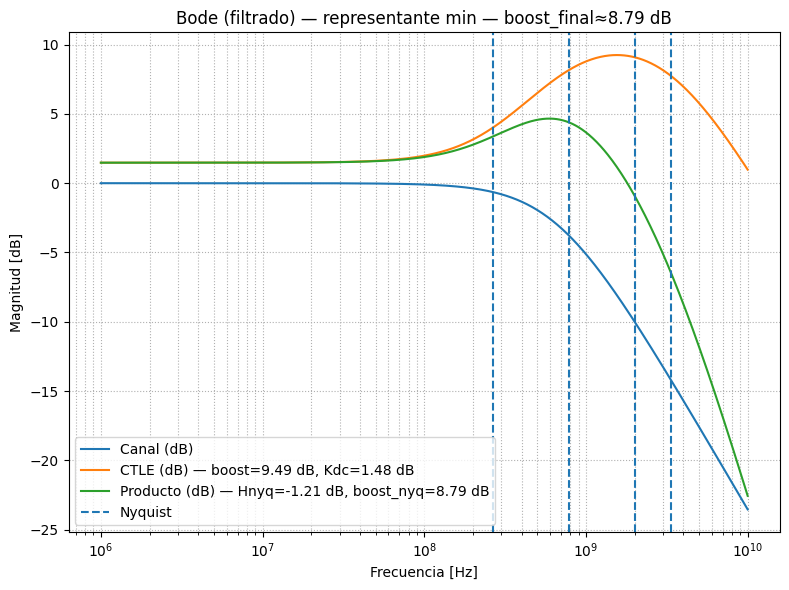

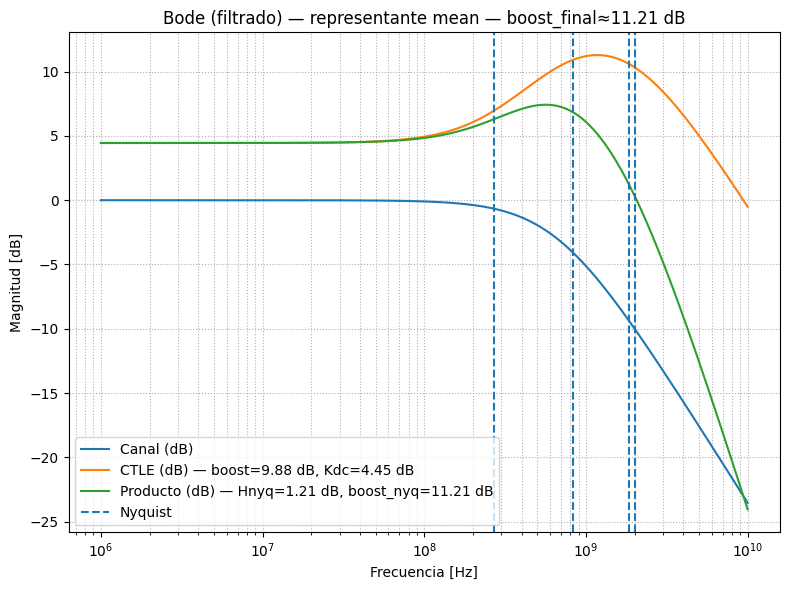

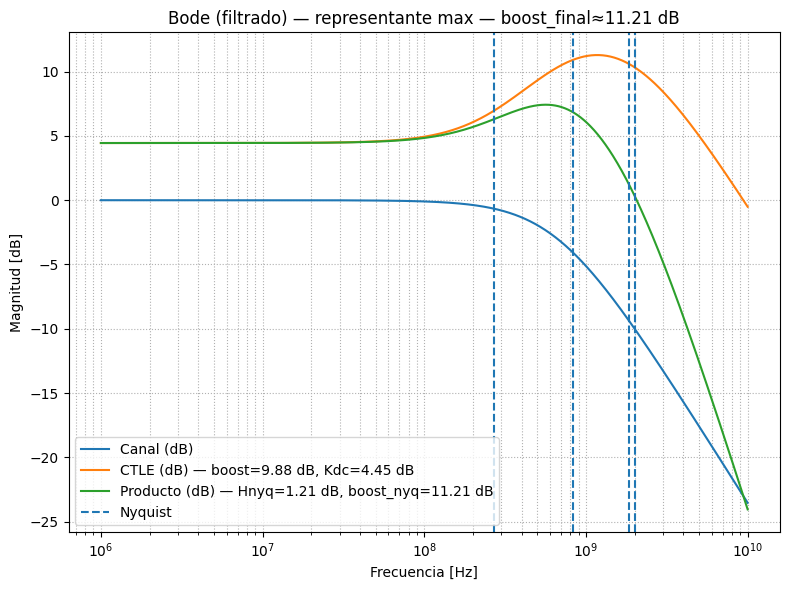

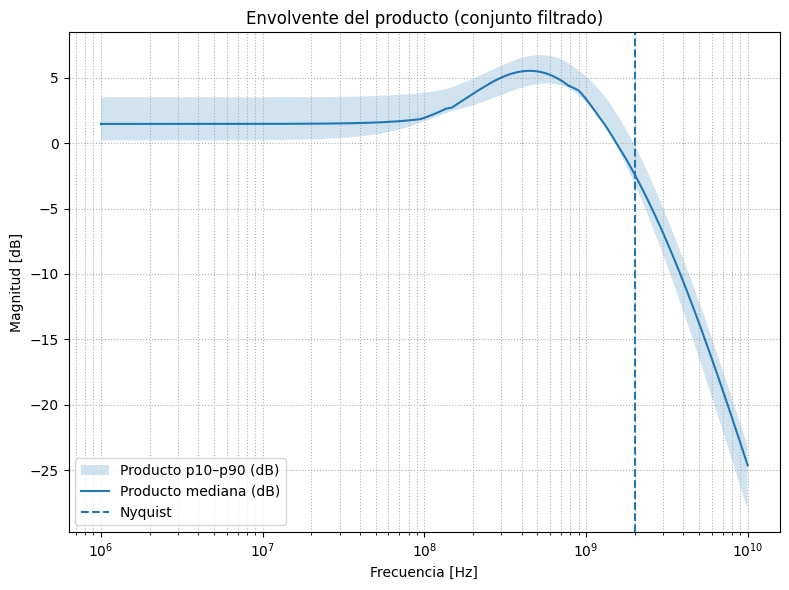


Guardadas estadísticas en:
 - ctle_filtered_design_stats_min_mean_max.csv
 - ctle_filtered_design_stats_units.csv


In [5]:
# bode_filtrado_desde_stats.py
# bode_filtrado_desde_stats.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Parámetros/Modelo ----------
f_nyq = 2e9
fmin, fmax = 1e6, 10e9
N_F = 1024
F = np.logspace(np.log10(fmin), np.log10(fmax), N_F)

ATTEN_DB = 10.0
fc = f_nyq / np.sqrt(10**(ATTEN_DB/10) - 1.0)

def H_ch_mag(f):
    w = 2*np.pi*f
    wc = 2*np.pi*fc
    return 1.0 / np.sqrt(1.0 + (w/wc)**2)

def ctle_params_to_freqs(RS, RD, CS, gm, CL):
    boost = 1.0 + gm*RS/2.0
    fz  = 1.0/(2*np.pi*RS*CS)
    fp1 = boost/(2*np.pi*RS*CS)
    fp2 = 1.0/(2*np.pi*RD*CL)
    Kdc = (gm*RD)/max(boost, 1e-18)
    return fz, fp1, fp2, boost, Kdc

def H_ctle_mag_vec(f, RS, RD, CS, gm, CL):
    fz, fp1, fp2, boost, Kdc = ctle_params_to_freqs(RS, RD, CS, gm, CL)
    w = 2*np.pi*f
    wz, wp1, wp2 = 2*np.pi*np.array([fz, fp1, fp2])
    num  = np.sqrt(1.0 + (w/wz)**2)
    den  = np.sqrt(1.0 + (w/wp1)**2) * np.sqrt(1.0 + (w/wp2)**2)
    return abs(Kdc) * (num/den)

def db(x):
    return 20*np.log10(np.maximum(x, 1e-18))

# ---------- Cargar datos ----------
# Preferimos el enriquecido (con columnas del producto). Si no existe, usar el factible básico.
try:
    df = pd.read_csv("ctle_sweep_feasible_with_product.csv")
except Exception:
    df = pd.read_csv("ctle_sweep_feasible.csv")

# Requisitos para filtrar/graficar
required_cols = {
    "RS","RD","CS","gm","CL","boost_db","Kdc_db",
    "Htot_nyq_db","peak_over_nyq_db","Htot_low_db","Htot_peak_db"
}
missing = required_cols - set(df.columns)
if missing:
    raise RuntimeError(f"Faltan columnas para filtrar/graficar: {sorted(missing)}. "
                       "Corré antes el script que agrega métricas del producto.")

# ---------- Filtro pedido ----------
# Producto con pico ≤ 1 dB y Htot_nyq_db alrededor de 0 dB ±1 dB
mask = (df["Htot_peak_db"].between(-5.0, +5.0) & df["Htot_nyq_db"].between(-5.0, +5.0) )
df_filt = df.loc[mask].copy()
print(f"Filtrados: {len(df_filt)} / {len(df)} (pico ≤1 dB y |Htot_nyq_db|≤1 dB)")

if df_filt.empty:
    raise SystemExit("No hay muestras que cumplan ambos criterios; ajustá tolerancias o rangos.")

# ---------- Estadísticas de parámetros de diseño ----------
design_cols_all = ["RS","RD","CS","gm","CL","fz","fp1","fp2","boost_db","Kdc_db"]
design_cols = [c for c in design_cols_all if c in df_filt.columns]
df_design = df_filt[design_cols].copy()

# min/mean/max
design_stats = pd.DataFrame({
    "min":  df_design.min(),
    "mean": df_design.mean(),
    "max":  df_design.max()
})

# Vista con unidades amigables (si existen esas columnas)
unit_view = pd.DataFrame()
def add_scaled_row(df_stats, col, scale, label):
    if col in df_stats.index:
        unit_view.loc[label, "min"]  = df_stats.loc[col, "min"]*scale
        unit_view.loc[label, "mean"] = df_stats.loc[col, "mean"]*scale
        unit_view.loc[label, "max"]  = df_stats.loc[col, "max"]*scale

add_scaled_row(design_stats, "RS",     1e-3,  "RS [kΩ]")
add_scaled_row(design_stats, "RD",     1e-3,  "RD [kΩ]")
add_scaled_row(design_stats, "CS",     1e12,  "CS [pF]")
add_scaled_row(design_stats, "gm",     1e3,   "gm [mS]")
add_scaled_row(design_stats, "CL",     1e15,  "CL [fF]")
add_scaled_row(design_stats, "fz",     1e-6,  "fz [MHz]")
add_scaled_row(design_stats, "fp1",    1e-6,  "fp1 [MHz]")
add_scaled_row(design_stats, "fp2",    1e-6,  "fp2 [MHz]")
add_scaled_row(design_stats, "boost_db", 1.0, "boost [dB]")
add_scaled_row(design_stats, "Kdc_db",   1.0, "Kdc [dB]")

# Guardar e imprimir
design_stats_path = "ctle_filtered_design_stats_min_mean_max.csv"
unit_stats_path   = "ctle_filtered_design_stats_units.csv"
design_stats.to_csv(design_stats_path)
if not unit_view.empty:
    unit_view.to_csv(unit_stats_path)

print("\n=== Estadísticas de diseño (SI) ===")
print(design_stats.round(3).to_string())

if not unit_view.empty:
    print("\n=== Optimal Design Stadistics ===")
    print(unit_view.round(3).to_string())

# ---------- Elegir 3 representantes (min / mean / max) en parámetros RS,RD,CS,gm,CL ----------
PAR_KEYS = [k for k in ["RS","RD","CS","gm","CL"] if k in df_filt.columns]

def logdist2(row, target):
    # Distancia cuadrática en log-espacio (cada eje ponderado = 1)
    d2 = 0.0
    for k in PAR_KEYS:
        d2 += (np.log10(row[k]) - np.log10(target[k]))**2
    return d2

# Estadísticos del conjunto filtrado en parámetros base
stats_par = {
    "min":  {k: float(df_filt[k].min())  for k in PAR_KEYS},
    "mean": {k: float(df_filt[k].mean()) for k in PAR_KEYS},
    "max":  {k: float(df_filt[k].max())  for k in PAR_KEYS},
}

# Encontrar la muestra real más cercana (en log) a cada vector min/mean/max
reps = {}
for tag in ["min","mean","max"]:
    tgt = stats_par[tag]
    idx = df_filt.apply(lambda r: logdist2(r, tgt), axis=1).astype(float).idxmin()
    reps[tag] = df_filt.loc[idx].to_dict()

print("\nRepresentantes elegidos (índices):",
      {t: int(df_filt.apply(lambda r: logdist2(r, stats_par[t]), axis=1).idxmin()) for t in reps})

# ---------- Graficar Bode para cada representante ----------
HCH = H_ch_mag(F)

for tag, r in reps.items():
    RS, RD, CS, gm, CL = r["RS"], r["RD"], r["CS"], r["gm"], r["CL"]
    fz, fp1, fp2, boost, Kdc = ctle_params_to_freqs(RS, RD, CS, gm, CL)

    Hctle = H_ctle_mag_vec(F, RS, RD, CS, gm, CL)
    Htot  = Hctle * HCH
    final_boost = ATTEN_DB + (r["Htot_nyq_db"])  # sólo a modo de nota en el título

    plt.figure(figsize=(8,6))
    plt.semilogx(F, db(HCH),               label="Canal (dB)")
    plt.semilogx(F, db(Hctle),             label=f"CTLE (dB) — boost={r['boost_db']:.2f} dB, Kdc={r['Kdc_db']:.2f} dB")
    plt.semilogx(F, db(Htot),              label=f"Producto (dB) — Hnyq={r['Htot_nyq_db']:.2f} dB, boost_nyq={final_boost:.2f} dB")
    plt.axvline(fz,   linestyle="--")
    plt.axvline(fp1,  linestyle="--")
    plt.axvline(fp2,  linestyle="--")
    plt.axvline(f_nyq, linestyle="--", label="Nyquist")
    plt.title(f"Bode (filtrado) — representante {tag} — boost_final≈{final_boost:.2f} dB")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Magnitud [dB]")
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Envolvente del producto del conjunto filtrado (opcional) ----------
def Htot_curve(row):
    RS, RD, CS, gm, CL = row["RS"], row["RD"], row["CS"], row["gm"], row["CL"]
    return H_ctle_mag_vec(F, RS, RD, CS, gm, CL) * HCH

MAX_SAMPLES = 400
df_env = df_filt.sample(n=min(len(df_filt), MAX_SAMPLES), random_state=0)

Htot_mat = np.vstack([Htot_curve(row) for _, row in df_env.iterrows()])
Htot_db_mat = 20*np.log10(np.maximum(Htot_mat, 1e-18))
p10 = np.percentile(Htot_db_mat, 10, axis=0)
p90 = np.percentile(Htot_db_mat, 90, axis=0)
med = np.percentile(Htot_db_mat, 50, axis=0)

plt.figure(figsize=(8,6))
plt.fill_between(F, p10, p90, alpha=0.2, label="Producto p10–p90 (dB)")
plt.semilogx(F, med, label="Producto mediana (dB)")
plt.axvline(f_nyq, linestyle="--", label="Nyquist")
plt.title("Envolvente del producto (conjunto filtrado)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nGuardadas estadísticas en:\n - {design_stats_path}")
if not unit_view.empty:
    print(f" - {unit_stats_path}")


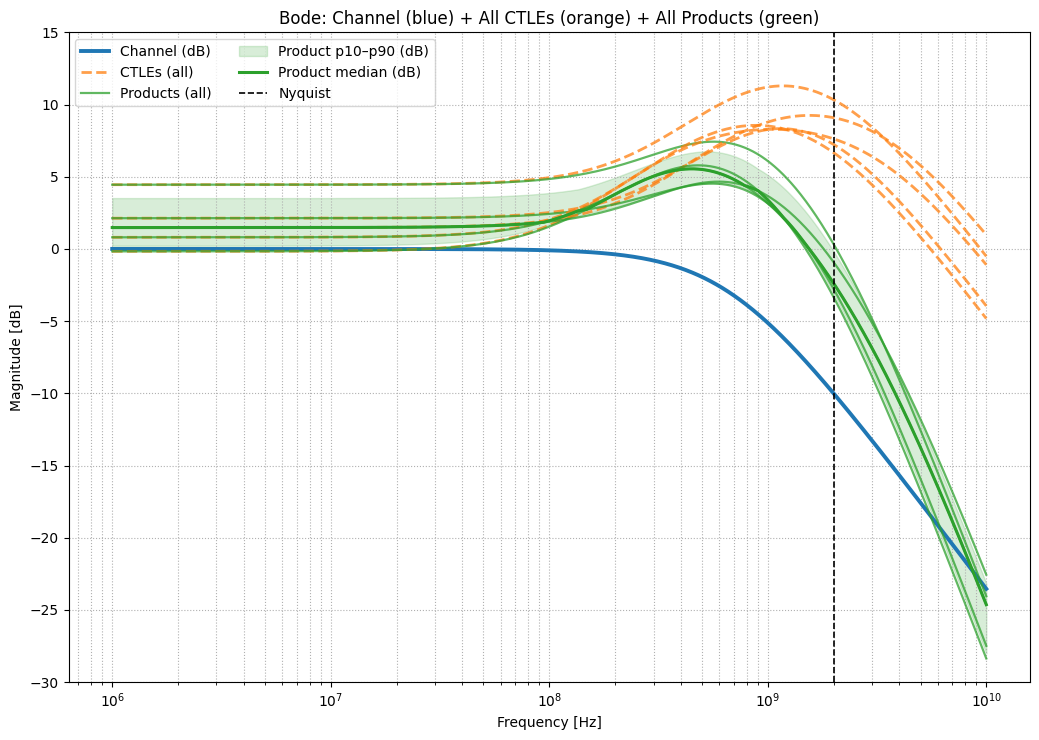

In [6]:
# ---------- ONE figure: Channel (blue) + ALL CTLEs (orange) + ALL Products (green) ----------
HCH = H_ch_mag(F)

# Colores fijos
COLOR_CH   = "#1f77b4"  # azul
COLOR_CTLE = "#ff7f0e"  # naranja
COLOR_PROD = "#2ca02c"  # verde

# Si hay demasiadas muestras, submuestreamos para que se vea todo
MAX_PLOTS = 1200
df_plot = df_filt if len(df_filt) <= MAX_PLOTS else df_filt.sample(n=MAX_PLOTS, random_state=0)

# Acumulador para banda p10–p90 y mediana del producto
Htot_db_list = []

plt.figure(figsize=(10.5, 7.5))

# Canal (una sola curva, más gruesa)
plt.semilogx(F, db(HCH), color=COLOR_CH, linewidth=2.8, label="Channel (dB)")

# Estilos visibles
ALPHA_CTLE = 0.75
ALPHA_PROD = 0.75
LW_CTLE    = 2
LW_PROD    = 1.6

first_ctle_label = True
first_prod_label = True

# Dibujar TODOS los CTLE y TODOS los productos
for _, r in df_plot.iterrows():
    RS, RD, CS, gm, CL = r["RS"], r["RD"], r["CS"], r["gm"], r["CL"]

    Hctle = H_ctle_mag_vec(F, RS, RD, CS, gm, CL)
    Htot  = Hctle * HCH

    Hctle_db = db(Hctle)
    Htot_db  = db(Htot)
    Htot_db_list.append(Htot_db)

    # CTLEs (naranja)
    plt.semilogx(
        F, Hctle_db, linestyle="--", linewidth=LW_CTLE, alpha=ALPHA_CTLE,
        color=COLOR_CTLE, label="CTLEs (all)" if first_ctle_label else None
    )
    first_ctle_label = False

    # Productos (verde)
    plt.semilogx(
        F, Htot_db, linestyle="-", linewidth=LW_PROD, alpha=ALPHA_PROD,
        color=COLOR_PROD, label="Products (all)" if first_prod_label else None
    )
    first_prod_label = False

# Banda p10–p90 y mediana del producto (verde)
if Htot_db_list:
    Htot_db_mat = np.vstack(Htot_db_list)
    p10 = np.percentile(Htot_db_mat, 10, axis=0)
    p90 = np.percentile(Htot_db_mat, 90, axis=0)
    med = np.percentile(Htot_db_mat, 50, axis=0)

    plt.fill_between(F, p10, p90, color=COLOR_PROD, alpha=0.18, label="Product p10–p90 (dB)")
    plt.semilogx(F, med, color=COLOR_PROD, linewidth=2.2, label="Product median (dB)")

# Marca de Nyquist
plt.axvline(f_nyq, linestyle="--", linewidth=1.2, color="k", label="Nyquist")

plt.title("Bode: Channel (blue) + All CTLEs (orange) + All Products (green)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.ylim([-30,15])
plt.grid(True, which="both", ls=":")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()




In [7]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
from pathlib import Path

def csv_to_s2p(
    csv_path,
    s2p_path=None,
    freq_col="frequency",
    mag_db_col='r dB(S[2,1])',      # |S21| in dB
    phase_deg_col='i dB(S[2,1])',   # ∠S21 in degrees
    z0=50.0,
    sep=';',
    decimal='.',                    # change to ',' if your CSV uses comma decimals
    header_lines=None,              # optional list[str] to inject as comment lines
):
    """
    Convert CSV with [freq, |S21|_dB, angle_deg] into a Touchstone .s2p (S in RI).
    S11=S12=S22=0 by default.
    """
    csv_path = Path(csv_path)
    if s2p_path is None:
        s2p_path = csv_path.with_suffix('.s2p')
    else:
        s2p_path = Path(s2p_path)

    # --- Read CSV (robust to quotes in headers) ---
    df = pd.read_csv(csv_path, sep=sep, decimal=decimal)
    # normalize column names (strip quotes/whitespace)
    df.columns = [c.strip().strip('"').strip("'") for c in df.columns]

    # --- Extract and sanity check ---
    for col in (freq_col, mag_db_col, phase_deg_col):
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found. Available: {list(df.columns)}")

    f_hz   = df[freq_col].to_numpy(float)               # Hz
    mag_db = df[mag_db_col].to_numpy(float)             # dB
    ang_deg= df[phase_deg_col].to_numpy(float)          # deg

    # --- Build S21 as complex (linear) ---
    mag_lin = 10.0**(mag_db/20.0)
    ang_rad = np.deg2rad(ang_deg)
    s21 = mag_lin * np.exp(1j*ang_rad)

    # --- Other S-parameters (placeholders = 0) ---
    s11 = np.zeros_like(s21, dtype=np.complex128)
    s12 = np.zeros_like(s21, dtype=np.complex128)
    s22 = np.zeros_like(s21, dtype=np.complex128)

    # --- Prepare data lines (Touchstone v1, S RI) ---
    # Row format: f  Re(S11) Im(S11)  Re(S21) Im(S21)  Re(S12) Im(S12)  Re(S22) Im(S22)
    data = np.column_stack([
        f_hz,
        np.real(s11), np.imag(s11),
        np.real(s21), np.imag(s21),
        np.real(s12), np.imag(s12),
        np.real(s22), np.imag(s22)
    ])

    # --- Write .s2p ---
    with open(s2p_path, 'w', encoding='utf-8') as f:
        # optional comment lines
        if header_lines:
            for line in header_lines:
                f.write(f"! {line}\n")
        f.write(f"! Auto-generated from {csv_path.name}\n")
        f.write(f"# Hz S RI R {z0:.6g}\n")
        # Touchstone typically allows whitespace-separated floats; use compact formatting
        np.savetxt(f, data, fmt="%.9g")

    print(f"Wrote: {s2p_path.resolve()}")

if __name__ == "__main__":
    # Example usage with your exact headers and CSV delimiter ';'
    csv_to_s2p(
        csv_path="1GHZ_10dB.csv",
        s2p_path="output.s2p",
        freq_col="frequency",
        mag_db_col="r dB(S[2,1])",
        phase_deg_col="i dB(S[2,1])",
        sep=';',            # your sample uses semicolons
        decimal='.',        # switch to ',' if needed
        header_lines=[
            "S21 from CSV: mag[dB], phase[deg]; S11=S12=S22=0 (placeholder).",
            "Edit the script if you need reciprocity or measured S11/S22."
        ]
    )


Wrote: C:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\output.s2p


In [8]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
from pathlib import Path

def csv_to_s4p_twoin_twoout(
    csv_path,
    s4p_path=None,
    freq_col="frequency",
    mag_db_col="r dB(S[2,1])",      # magnitud dB
    phase_deg_col="i dB(S[2,1])",   # fase en grados
    sep=';',
    decimal='.',
    z0=50.0,
    topology="single_ended_pair",   # "single_ended_pair" o "differential_pair"
    reciprocal=False                # si True, copia caminos inversos
):
    """
    Genera .s4p válido para Cadence (Hz, S, RI, R=50) con 2 entradas (puertos 1-2)
    y 2 salidas (puertos 3-4).

    topology="single_ended_pair":
        S31 = S42 = S_csv; resto 0.
        (opcional reciprocal=True → S13 = S24 = S_csv)
    topology="differential_pair":
        Interpreta CSV como Sdd21 puro (sin modo común).
        Embebido single-ended ideal:
            S31 = +S/2, S41 = -S/2, S32 = -S/2, S42 = +S/2; resto 0.
        (opcional reciprocal=True → caminos inversos con misma regla)
    """
    csv_path = Path(csv_path)
    if s4p_path is None:
        s4p_path = csv_path.with_suffix('.s4p')
    else:
        s4p_path = Path(s4p_path)

    df = pd.read_csv(csv_path, sep=sep, decimal=decimal)
    df.columns = [c.strip().strip('"').strip("'") for c in df.columns]

    f_hz   = df[freq_col].to_numpy(float)
    mag_db = df[mag_db_col].to_numpy(float)
    ang_deg= df[phase_deg_col].to_numpy(float)

    mag_lin = 10.0**(mag_db/20.0)
    ang_rad = np.deg2rad(ang_deg)
    S = mag_lin * np.exp(1j*ang_rad)   # curva compleja desde el CSV

    N = len(f_hz)
    S4 = np.zeros((N, 4, 4), dtype=np.complex128)

    if topology == "single_ended_pair":
        # entradas: 1,2 — salidas: 3,4
        # Caminos directos “through” por línea 1→3 y 2→4
        S4[:, 2, 0] = S    # S31
        S4[:, 3, 1] = S    # S42
        if reciprocal:
            S4[:, 0, 2] = S  # S13
            S4[:, 1, 3] = S  # S24

    elif topology == "differential_pair":
        # Par diferencial (1,2) → (3,4), Sdd21 = S (puro modo impar, sin modo común)
        # Embedding single-ended ideal:
        #   b3 = +S/2 * a1  + (-S/2) * a2
        #   b4 = -S/2 * a1  + (+S/2) * a2
        S_half = 0.5 * S
        S4[:, 2, 0] = +S_half  # S31
        S4[:, 2, 1] = -S_half  # S32
        S4[:, 3, 0] = -S_half  # S41
        S4[:, 3, 1] = +S_half  # S42
        if reciprocal:
            # Camino inverso (3,4)->(1,2) con la misma estructura
            S4[:, 0, 2] = +S_half  # S13
            S4[:, 1, 2] = -S_half  # S23
            S4[:, 0, 3] = -S_half  # S14
            S4[:, 1, 3] = +S_half  # S24
    else:
        raise ValueError("topology debe ser 'single_ended_pair' o 'differential_pair'")

    # Escribe Touchstone v1: # Hz S RI R 50
    with open(s4p_path, 'w', encoding='utf-8') as f:
        f.write(f"! Generated from {csv_path.name}\n")
        f.write(f"! Topology: {topology}; reciprocal={reciprocal}\n")
        f.write(f"# Hz S RI R {z0:.6g}\n")
        for i, freq in enumerate(f_hz):
            row = [freq]
            for r in range(4):
                for c in range(4):
                    z = S4[i, r, c]
                    row.extend([np.real(z), np.imag(z)])
            f.write(" ".join(f"{v:.9g}" for v in row) + "\n")

    print(f"OK → {s4p_path.resolve()}")

if __name__ == "__main__":
    # Ejemplos de uso:
    # 1) Par single-ended (1,2) → (3,4), paths 1→3 y 2→4:
    # csv_to_s4p_twoin_twoout("input.csv", topology="single_ended_pair", reciprocal=False)
    #
    # 2) Par diferencial (1,2) → (3,4) interpretando el CSV como Sdd21:
    # csv_to_s4p_twoin_twoout("input.csv", s4p_path="diff_embedded.s4p",
    #                          topology="differential_pair", reciprocal=True)
    csv_to_s4p_twoin_twoout("input.csv", topology="single_ended_pair", reciprocal=False)


OK → C:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\input.s4p


In [9]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
from pathlib import Path

def csv_to_s4p_twoin_twoout(
    csv_path,
    s4p_path=None,
    freq_col="frequency",
    mag_db_col="r dB(S[2,1])",      # magnitud dB
    phase_deg_col="i dB(S[2,1])",   # fase en grados
    sep=';',
    decimal='.',
    z0=50.0,
    topology="single_ended_pair",   # "single_ended_pair" | "differential_pair"
    reciprocal=False,
    diag_epsilon=0.0                # p.ej. 1e-6 para Sii=1e-6+0j si querés evitar singularidad
):
    """
    Genera .s4p (Hz, S, RI, R=z0) con 2 entradas (puertos 1-2) y 2 salidas (puertos 3-4).
    Escribe Touchstone v1 en ORDEN POR COLUMNAS (requerido por Spectre).

    topology="single_ended_pair":
        S31 = S42 = S; resto 0 (y opcional reciproco).
    topology="differential_pair":
        Interpreta CSV como Sdd21. Embedding ideal en single-ended:
            S31=+S/2, S32=-S/2, S41=-S/2, S42=+S/2 (y opcional reciproco).
    """
    csv_path = Path(csv_path)
    if s4p_path is None:
        s4p_path = csv_path.with_suffix('.s4p')
    else:
        s4p_path = Path(s4p_path)

    df = pd.read_csv(csv_path, sep=sep, decimal=decimal)
    df.columns = [c.strip().strip('"').strip("'") for c in df.columns]

    f_hz   = df[freq_col].to_numpy(float)
    mag_db = df[mag_db_col].to_numpy(float)
    ang_deg= df[phase_deg_col].to_numpy(float)

    mag_lin = 10.0**(mag_db/20.0)
    ang_rad = np.deg2rad(ang_deg)
    S = mag_lin * np.exp(1j*ang_rad)   # curva compleja desde el CSV

    Nf = len(f_hz)
    S4 = np.zeros((Nf, 4, 4), dtype=np.complex128)

    if topology == "single_ended_pair":
        # entradas: 1,2 — salidas: 3,4
        S4[:, 2, 0] = S  # S31
        S4[:, 3, 1] = S  # S42
        if reciprocal:
            S4[:, 0, 2] = S  # S13
            S4[:, 1, 3] = S  # S24

    elif topology == "differential_pair":
        S_half = 0.5 * S
        S4[:, 2, 0] = +S_half  # S31
        S4[:, 2, 1] = -S_half  # S32
        S4[:, 3, 0] = -S_half  # S41
        S4[:, 3, 1] = +S_half  # S42
        if reciprocal:
            S4[:, 0, 2] = +S_half  # S13
            S4[:, 1, 2] = -S_half  # S23
            S4[:, 0, 3] = -S_half  # S14
            S4[:, 1, 3] = +S_half  # S24
    else:
        raise ValueError("topology debe ser 'single_ended_pair' o 'differential_pair'")

    # Opcional: agregar un epsilon en diagonales (S11..S44) para evitar matrices totalmente nulas
    if diag_epsilon and diag_epsilon > 0:
        for k in range(4):
            S4[:, k, k] = diag_epsilon + 0j

    # -------- Escritura Touchstone v1: ORDEN POR COLUMNAS --------
    # Secuencia por línea:
    # f  (S11 Re Im S21 Re Im S31 Re Im S41 Re Im) (S12 ...) (S13 ...) (S14 ...)
    with open(s4p_path, 'w', encoding='utf-8') as f:
        f.write(f"! Generated from {csv_path.name}\n")
        f.write(f"! Topology={topology}; reciprocal={reciprocal}; diag_epsilon={diag_epsilon}\n")
        f.write(f"# Hz S RI R {z0:.6g}\n")
        for i, freq in enumerate(f_hz):
            row = [f"{freq:.9g}"]
            # columnas (c = 0..3), dentro de cada columna se listan filas (r = 0..3)
            for c in range(4):
                for r in range(4):
                    z = S4[i, r, c]
                    row.append(f"{np.real(z):.9g}")
                    row.append(f"{np.imag(z):.9g}")
            f.write(" ".join(row) + "\n")

    print(f"OK → {s4p_path.resolve()}")

if __name__ == "__main__":
    # ejemplo mínimo
    csv_to_s4p_twoin_twoout(
        "input.csv",
        topology="single_ended_pair",
        reciprocal=False,
        diag_epsilon=0.0
    )


OK → C:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\input.s4p


In [10]:
#!/usr/bin/env python3
"""
CSV -> Touchstone .s2p (2 puertos, single-ended)
Lee:  frequency ; |S21|_dB ; angle_deg
Escribe: # Hz S RI R 50, orden por columnas: S11 S21  S12 S22
"""

import sys
import argparse
import numpy as np
import pandas as pd
from pathlib import Path

def csv_to_s2p(
    csv_path,
    s2p_path=None,
    freq_col="frequency",
    mag_db_col='r dB(S[2,1])',
    phase_deg_col='i dB(S[2,1])',
    sep=';',
    decimal='.',
    z0=50.0,
    reciprocal=False,
    add_diag_eps=0.0,
):
    csv_path = Path(csv_path)
    s2p_path = Path(s2p_path) if s2p_path else csv_path.with_suffix('.s2p')

    # Leer CSV y normalizar encabezados
    df = pd.read_csv(csv_path, sep=sep, decimal=decimal)
    df.columns = [c.strip().strip('"').strip("'") for c in df.columns]

    for col in (freq_col, mag_db_col, phase_deg_col):
        if col not in df.columns:
            raise KeyError(f"Falta columna '{col}'. Disponibles: {list(df.columns)}")

    f_hz   = df[freq_col].to_numpy(float)
    mag_db = df[mag_db_col].to_numpy(float)
    ang_deg= df[phase_deg_col].to_numpy(float)

    # dB/deg -> complejo
    S21_mag = 10.0**(mag_db/20.0)
    S21_ang = np.deg2rad(ang_deg)
    S21 = S21_mag * np.exp(1j*S21_ang)

    # Matriz S (N x 2 x 2)
    N = len(f_hz)
    S = np.zeros((N, 2, 2), dtype=np.complex128)
    S[:, 1, 0] = S21
    if reciprocal:
        S[:, 0, 1] = S21
    if add_diag_eps and add_diag_eps > 0:
        S[:, 0, 0] = add_diag_eps + 0j
        S[:, 1, 1] = add_diag_eps + 0j

    # Escribir Touchstone v1 (orden por columnas)
    with open(s2p_path, 'w', encoding='utf-8') as fo:
        fo.write(f"! Generated from {csv_path.name}\n")
        fo.write(f"! S21 from CSV; S11,S22,S12={'S21' if reciprocal else '0'}\n")
        fo.write(f"# Hz S RI R {z0:.6g}\n")
        for i, freq in enumerate(f_hz):
            row = [f"{freq:.9g}"]
            for c in range(2):         # columnas: 0..1
                for r in range(2):     # filas: 0..1
                    z = S[i, r, c]
                    row.append(f"{np.real(z):.9g}")
                    row.append(f"{np.imag(z):.9g}")
            fo.write(" ".join(row) + "\n")

    print(f"OK → {s2p_path.resolve()}")
    if N:
        print(f"Ganancia ~DC: {mag_db[0]:.6f} dB  → |S21|={S21_mag[0]:.9f}")

if __name__ == "__main__":
    # Parser que ignora argumentos desconocidos (como los de Jupyter)
    parser = argparse.ArgumentParser(description="CSV -> .s2p")
    parser.add_argument("input", nargs="?", help="CSV de entrada")
    parser.add_argument("output", nargs="?", help="Archivo .s2p de salida")
    parser.add_argument("--reciprocal", action="store_true", help="Forzar S12=S21")
    parser.add_argument("--diag-eps", type=float, default=0.0, help="Epsilon diagonal Sii")
    args, _unknown = parser.parse_known_args()

    if args.input:
        csv_to_s2p(args.input, args.output,
                   reciprocal=args.reciprocal,
                   add_diag_eps=args.diag_eps)
    else:
        # Modo notebook: no exigir argv; no falla si Jupyter pasa --f=...
        print("Sin argumentos de CLI: importá y llamá csv_to_s2p('input.csv','output.s2p').")




Sin argumentos de CLI: importá y llamá csv_to_s2p('input.csv','output.s2p').


In [11]:
# En tu notebook:
csv_to_s2p("att20dB_14G.csv", "att20dB_14G.s2p",
           reciprocal=False, add_diag_eps=0.0)


OK → C:\Users\leiit\Desktop\Maestria-Fulgor\Tesis\CTLE\att20dB_14G.s2p
Ganancia ~DC: -1.580870 dB  → |S21|=0.833597685
